# The Battle Of The Neighbourhood

### 1. Description of the problem and discussion of the background

Every cities has venues, like cafes, parcs, clothes shops, books stores etc... A city can also be defined by its urban perimeter and its population.
I would like to throw the light on the link between area, population, number of stores to see if there are cities that could be clustered together. The second point after that, would be to know which city could develop which kind of venues to compete with the cities of a same cluster.

<b>The first week</b> will be about the data gathering thanks to wikipedia and foursquare mainly. Data scrapping with <i>beautifulsoup</i> and gather the data with the <i>foursquare API</i>.

I'll then define the different clusters of cities if I can compare them.

<b>The second week</b> will be about defining the model to define good proportions for a city in terms of venues.

### 2. Description of the data and how it will be used to solve the problem

First we will use the wipidedia page to find a list of the biggest city, their population and the urban area.
We are lucky, we can find it in a table on this page: https://en.wikipedia.org/wiki/List_of_largest_cities

In [1]:
!pip install geocoder
!pip install beautifulsoup4
!pip install lxml
!pip install folium

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np


 
req = requests.get('https://en.wikipedia.org/wiki/List_of_largest_cities')
soup = BeautifulSoup(req.text, "lxml") 

In [3]:
soup.find_all('tr')[253].text

'\nCartagena\n\n\xa0Colombia\n\n\n\n1,013,389[220]\n\n1,013,389\n\n1,013,389\n'

In [4]:
rows=soup.find_all('tr')[5:254]
cities=[row.find_all('th') for row in rows]
rows1=[row.find_all('td') for row in rows]

In [5]:
cities=[ row[0].text for row in cities]
rows2=[[data.text for data in row]for row in rows1]
rows2.pop(0)
cities.pop(0)
cities[:4]

['Chongqing\n', 'Shanghai\n', 'Beijing\n', 'Lagos\n']

In [6]:
for city,row in zip(cities,rows2):
    row.insert(0, city)

In [7]:
for row in rows2:
    for i in range(len(row)):
        row[i]=row[i].replace('\n','')
        row[i]=row[i].replace(',','')
rows2[:4]

[['Chongqing', '\xa0China', '', '30751600[8]', '17000000[9]', '8165500[a]'],
 ['Shanghai', '\xa0China', '', '24256800[11]', '24750000[12]', '23416000[b]'],
 ['Beijing', '\xa0China', '', '21516000[13]', '24900000[14]', '21009000'],
 ['Lagos', '\xa0Nigeria', '', '16060303[c]', '21000000[17]', '13123000']]

In [8]:
for row in rows2:
        row.pop(2)

In [9]:
import re
import copy
a=''
for i, row in enumerate(rows2):
    for j, data in enumerate(row):
            if data!= '':
                if data[0]=='\xa0':
                    a=rows2[i][j]=re.sub(r'\[.*\]','',row[j][1:])
                else:
                    a=rows2[i][j]=re.sub(r'\[.*\]','',row[j])
            else:
                a=''
            rows2[i][j]=a
            
            
rows2[:4]

[['Chongqing', 'China', '30751600', '17000000', '8165500'],
 ['Shanghai', 'China', '24256800', '24750000', '23416000'],
 ['Beijing', 'China', '21516000', '24900000', '21009000'],
 ['Lagos', 'Nigeria', '16060303', '21000000', '13123000']]

In [10]:
columns=['City','Country','Population city','Population Metro','Population Urban']
df=pd.DataFrame(data=rows2, columns=columns)

In [11]:
df.dtypes

City                object
Country             object
Population city     object
Population Metro    object
Population Urban    object
dtype: object

In [12]:
df[['Population city',
    'Population Metro',
    'Population Urban']] = df[['Population city',
                               'Population Metro',
                               'Population Urban']].apply(pd.to_numeric)
df[['City','Country']].astype(str)
df.dtypes

City                 object
Country              object
Population city     float64
Population Metro    float64
Population Urban    float64
dtype: object

In [13]:
df.head()

,City,Country,Population city,Population Metro,Population Urban
0,Chongqing,China,30751600.0,17000000.0,8165500.0
1,Shanghai,China,24256800.0,24750000.0,23416000.0
2,Beijing,China,21516000.0,24900000.0,21009000.0
3,Lagos,Nigeria,16060303.0,21000000.0,13123000.0
4,Dhaka,Bangladesh,8906039.0,20000000.0,NaN


We now have our first datas, we are gonna try to complete the missing datas in order to use them as parameter.  
Let see if the <b>Population city</b> , the <b>Population Metro</b> and <b>Population Urbam</b> are correlated.

In [14]:
df.corr()

,Population city,Population Metro,Population Urban
Population city,1.000000,0.756282,0.554156
Population Metro,0.756282,1.000000,0.872698
Population Urban,0.554156,0.872698,1.000000


In [15]:
import matplotlib.pyplot as plt

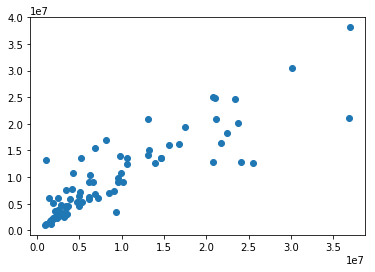

In [16]:
plt.scatter(df['Population Urban'],df['Population Metro'])

In [17]:
df.isna().sum()

City                  0
Country               0
Population city       1
Population Metro    100
Population Urban    142
dtype: int64

There is a lot of missing datas, there are different possibilities, filling them by copying the other columns, using predictions, or dropping them.
I'm gonna try to figure out a model quickly, if it is not accurate enough, I'm just gonna drop this datas and keep the <b>Population city</b>.

In [18]:
dffull=df.dropna()
dffull.shape

(81, 5)

In [19]:
dffull.corr()

,Population city,Population Metro,Population Urban
Population city,1.000000,0.719877,0.547026
Population Metro,0.719877,1.000000,0.872698
Population Urban,0.547026,0.872698,1.000000


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [21]:
X_train, X_test, y_train, y_test= train_test_split(dffull[['Population city','Population Metro']],
                                                   dffull[['Population Urban']],
                                                  test_size=0.15, random_state=42)

In [22]:
reg=LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [23]:
predict=reg.predict(X_test)

In [24]:
r2_score(y_test,predict)

0.37732593178856166

R2 score is really <b>LOW</b> : 0.3773  
The model is definitely not accurate enough to fill the missing datas. Now I'd rather keep the datas that are full : the <i>Population city</i> will be kept only

In [25]:
dffull=df.drop('Population Metro', axis=1)
dffull.drop('Population Urban', axis=1, inplace=True)
dffull.dropna(inplace=True)
dffull=dffull.reset_index(drop=True)
dffull.shape

(247, 3)

In [26]:
dffull.head(2)

,City,Country,Population city
0,Chongqing,China,30751600.0
1,Shanghai,China,24256800.0


### Complete the datas with geolocation infos

I am going to use <b>geocoder</b> to fill the location datas of every citys.

In [27]:
import geocoder

In [28]:
def get_latlng(place):
    # initialize variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis(place)
        lat_lng_coords = g.latlng
    return lat_lng_coords
    
get_latlng('Chongqing, China')

[29.562780000000032, 106.55278000000004]

In [29]:
def get_place(dataframe):
    
    return(', '.join([dataframe['City'],dataframe['Country']]))

In [30]:
places=pd.DataFrame(columns=['place'],data=dffull.apply(get_place, axis=1))
places.head()

,place
0,"Chongqing, China"
1,"Shanghai, China"
2,"Beijing, China"
3,"Lagos, Nigeria"
4,"Dhaka, Bangladesh"


In [31]:
places['Latitude']=''
places['Longitude']=''
coords=pd.DataFrame(columns=['Latitude','Longitude'],data=(places.apply(get_latlng, axis=1)).tolist())

In [32]:
print(dffull.shape,coords.shape)

(247, 3) (247, 2)


In [33]:
dffull=pd.concat([dffull,coords], axis=1)
dffull.head(2)

,City,Country,Population city,Latitude,Longitude
0,Chongqing,China,30751600.0,29.56278,106.55278
1,Shanghai,China,24256800.0,31.22222,121.45806


### Now let's print it on a map :D

In [34]:
import folium

In [35]:
map = folium.Map(location=[48.864716, 2.349014], zoom_start=2)
for i, point in dffull.iterrows():
    folium.Circle(location=[point['Latitude'],point['Longitude']],
                  popup=str(point['City'])+'\npop: '+str(format(int(point['Population city']),',')),
                  radius=point['Population city']/75,
                  color='purple',
                  fill=True,
                  fill_color='purple').add_to(map)

map

### We will now complete the database thanks to foursquare

In [36]:
#Edited for confidentiality reasons
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20190427'
LIMIT = 100
radius = 1000
location=[dffull['Latitude'][1],dffull['Longitude'][1]]
location

[31.22222000000005, 121.45806000000005]

In [37]:
url = 'https://api.foursquare.com/v2/venues/explore?'\
    '&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    location[0],
    location[1],
    radius,
    LIMIT
    )
results = requests.get(url).json()

In [38]:
venues = results['response']['groups'][0]['items']
nearby_venues = pd.io.json.json_normalize(venues)

In [39]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
def get_category_type(dataframe):
    return(dataframe['venue.categories'][0]['name'])
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Gentle Monster,Optical Shop,31.220255,121.458284
1,Di Shui Dong (滴水洞),Hunan Restaurant,31.223116,121.455691
2,Kee Club,Club House,31.220879,121.458103
3,O Theatre,Cocktail Bar,31.222604,121.455659
4,MUJI (无印良品),Furniture / Home Store,31.220615,121.459572


In [40]:
nearby_venues.shape

(100, 4)

In [41]:
map = folium.Map(location=location, zoom_start=11)
for i, point in nearby_venues.iterrows():
    folium.Marker(location=[point['lat'],point['lng']],
                  popup=str(point['name'])).add_to(map)

map

In [42]:
a=nearby_venues.groupby('categories').count()
a.shape

(60, 3)

The explore function of the API provides a maximum of 100 venues. It's not a lot of venues to identify the cities by their venues. Quick multiplication: I have 247 cities, And I can make 99500 calls a day. 99500/250=398.
I can multiply the number of datas by 4. To do that, I'm gonna take 4 points that are around the center and call the explore function from there.

In [43]:
locations=[[dffull['Latitude'][1],dffull['Longitude'][1]],
           [dffull['Latitude'][1],dffull['Longitude'][1]+0.03],
           [dffull['Latitude'][1],dffull['Longitude'][1]-0.03],
           [dffull['Latitude'][1]+0.03,dffull['Longitude'][1]],
           [dffull['Latitude'][1]-0.03,dffull['Longitude'][1]]]

In [44]:
map = folium.Map(location=location, zoom_start=11)
for location in locations:
    folium.Marker(location=location).add_to(map)

map

In [45]:
LIMIT = 100
radius = 1000

In [46]:
frames=[]
for location in locations:
    url = 'https://api.foursquare.com/v2/venues/explore?'\
        '&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        location[0],
        location[1],
        radius,
        LIMIT
        )
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    nearby_venues = pd.io.json.json_normalize(venues)
    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]
    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    frames.append(nearby_venues)

result = pd.concat(frames)

In [47]:
map = folium.Map(location=location, zoom_start=11)
for i, point in result.iterrows():
    folium.Marker(location=[point['lat'],point['lng']],
                  popup=str(point['name'])).add_to(map)

map

In [48]:
result.shape

(289, 4)

In [49]:
result1=pd.get_dummies(result,columns=['categories'],prefix='',prefix_sep='')
a=pd.DataFrame(result1.filter(result1.columns[3:]).sum()).transpose()
a=a/a.sum(axis=1)[0]
a

,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Bakery,Bar,Beer Bar,Bistro,Boat or Ferry,Brazilian Restaurant,...,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar,Xinjiang Restaurant,Yoga Studio
0,0.00346,0.00692,0.00346,0.010381,0.00692,0.017301,0.00692,0.00346,0.00692,0.00346,...,0.00346,0.00346,0.00346,0.00346,0.00346,0.00692,0.00346,0.00692,0.00346,0.00346


In [50]:
def get_venues_city(city):
    a=pd.DataFrame()
    locations=[[city['Latitude'],city['Longitude']],
           [city['Latitude'],city['Longitude']+0.03],
           [city['Latitude'],city['Longitude']-0.03],
           [city['Latitude']+0.03,city['Longitude']],
           [city['Latitude']-0.03,city['Longitude']]]
    frames=[]
    for location in locations:
        nearby_venues = None
        url = 'https://api.foursquare.com/v2/venues/explore?'\
            '&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            location[0],
            location[1],
            radius,
            LIMIT
            )
        results = requests.get(url).json()
        try:
            venues = results['response']['groups'][0]['items']
            nearby_venues = pd.io.json.json_normalize(venues)
        except:{}
            
        if not(nearby_venues.empty):
            # filter columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues =nearby_venues.loc[:, filtered_columns]
            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
            # clean columns
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
            frames.append(nearby_venues)
    
    if frames:
        result = pd.concat(frames)
        result1=pd.get_dummies(result,columns=['categories'],prefix='',prefix_sep='')
        a=pd.DataFrame(result1.filter(result1.columns[3:]).sum()).transpose()
        a=a/a.sum(axis=1)[0]
    else:
        a=pd.DataFrame({'empty':[1]})
    return(a)

In [ ]:
results=pd.DataFrame()

In [ ]:
for i, city in dffull.iterrows():
    result=get_venues_city(city)
    results=results.append(result)


In [ ]:
results.shape

In [52]:
dffull.shape

(247, 5)

In [ ]:
results.to_csv(path_or_buf='results.csv')

In [51]:
results=pd.read_csv('results.csv')
results.head()

,Unnamed: 0,ATM,Abruzzo Restaurant,Acai House,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Xinjiang Restaurant,Yakitori Restaurant,Yemeni Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit,empty
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003484,NaN,NaN,0.003484,NaN,0.003484,NaN,NaN,NaN,NaN
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.013468,NaN,NaN,NaN,NaN
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
datas=dffull.join(results)

In [82]:
datas=datas[datas['empty']!=1]

In [83]:
datas.drop(columns='Unnamed: 0',inplace=True,axis=1)
datas.fillna(0, inplace= True)
datas.head()

,City,Country,Population city,Latitude,Longitude,ATM,Abruzzo Restaurant,Acai House,Accessories Store,Adult Boutique,...,Xinjiang Restaurant,Yakitori Restaurant,Yemeni Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit,empty
0,Chongqing,China,30751600.0,29.56278,106.55278,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,Shanghai,China,24256800.0,31.22222,121.45806,0.0,0.0,0.0,0.0,0.0,...,0.003484,0.0,0.0,0.003484,0.0,0.003484,0.0,0.0,0.0,0.0
2,Beijing,China,21516000.0,39.90750,116.39723,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.013468,0.0,0.0,0.0,0.0
3,Lagos,Nigeria,16060303.0,6.45471,3.38876,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,Dhaka,Bangladesh,8906039.0,23.71323,90.39957,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


We now have all the datas we wanna work with ! a list of the biggest cities and a the proportions of the venues next to every city.
I am now gonna save this datas on my computer as a CSV. Next week, I am gonna exploit this datas to find the cluster of the different cities based on the proportions of their stores.

In [84]:
datas.to_csv(path_or_buf='datas.csv')